In [276]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

In [277]:
class DataAction:
  """
      The nuclear data-processing method.

  """

  def __init__(self):
    self.imp = None
    self.df = None
    self.chunk_size = 10000
    self.dfList = []


  def data_imp(self, file_name):
    # import from data location
    folder_path = '..\\data\\'
    file_path = folder_path + file_name
    self.imp = pd.read_csv(file_path, low_memory = False)


  def data_filter(self, df, keep_cols):
    # Process df inplace
    col_names = df.columns.tolist()
    for col in keep_cols:
        col_names.remove(col)
    df.drop(columns=col_names, inplace = True)
    df.dropna(inplace=True)
    df.rename(columns = {'cet_cest_timestamp':'date_time'}, inplace = True)
    self.df = df.set_index('date_time')


  def df_split(self, chunk_size):
    # splits the dataframe into smaller dataframes
    for i in range(0, self.df.shape[0], chunk_size):
        self.dfList.append(self.df[i:i+chunk_size])
    print('Number of data frame segments = ', len(self.dfList))


  def imp_procc(self, file_name, keep_cols):
    # easy import, data filter and split
    self.data_imp(file_name)
    self.data_filter(self.imp, keep_cols)
    self.df_split(self.chunk_size)
    print("dfList created successfully.")


  def parse_procc(self, df):
    # parse dates and convert index to time series
    # take the row difference and drop first NaN
    df.index = pd.to_datetime(df.index, exact=True, cache=True, format='%Y-%m-%d %H:%M:%S', dayfirst=True)
    ts = df.diff()
    ts.drop(str(ts.index[0]), inplace=True) # drop first NaN row
    return ts


  def unique_date(self, df): # helper function
    # find unique days in the time-series index df
    return df.index.map(lambda t: str(t.date())).unique().tolist()


  def get_night(self, ts, evening_date, start_time, end_time):
    # get the dates for loc slice
    start = evening_date + ' ' + start_time
    foo = pd.to_datetime(evening_date)
    bar = foo.replace(hour=int(end_time[0:2]), minute=int(end_time[3:5]), second=int(end_time[6:8])).strftime('%H:%M:%S')
    end = str(foo + timedelta(days=1))[:11] + bar

    # check for available date
    dates = self.unique_date(ts)
    if evening_date in dates:
        # print("Date is accepted.")
        return ts.loc[start : end]
    else:
        print("Error: Evening_date is not part of the selected dataset!")


  def time_wind(self, ts, wind_length):
    # select random night time window of length wind_length
    length = len(ts.index) - wind_length
    time_0 = np.random.randint(0,length)
    foo = night_mw.index[time_0]

    start = foo.strftime('%Y-%m-%d %H:%M:%S')
    bar = foo + timedelta(minutes=wind_length)
    end = bar.strftime('%Y-%m-%d %H:%M:%S')

    print(start)
    print(end)
    
    return start, end


  def sgen_write(self, ts, start, end, col_name, val):
      # write sgen val to df on col in time window
      ts.loc[start : end, col_name] = val
      return ts
  

In [278]:
da = DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)

Number of data frame segments =  90
dfList created successfully.


Mean W each min: 
 load_1 =  474.8433594009934 
 load_2 =  160.96829151415017


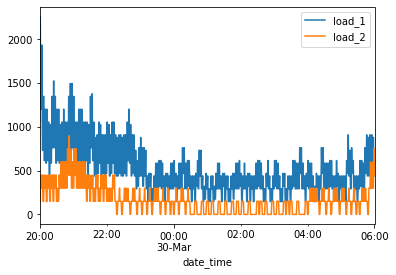

In [279]:
ts = da.parse_procc(da.dfList[45])
night = da.get_night(ts, da.unique_date(ts)[0], '20:00:00', '06:00:00').copy()

names = {'DE_KN_residential1_grid_import': 'load_1',
         'DE_KN_residential2_grid_import': 'load_2'}
night.rename(columns = names, inplace=True)

factor = 1000*(60*60)/60
night = night*factor
night.plot()
print("Mean W each min:", "\n load_1 = ", night.load_1.mean(), "\n load_2 = ", night.load_2.mean())

In [280]:
# convert to mw
night_mw = night/1000000
night_mw.insert(1, 'sgen_1', 0)
night_mw.insert(3, 'sgen_2', 0)
night_mw.head()

,load_1,sgen_1,load_2,sgen_2
date_time,,,,
2016-03-29 20:00:00+02:00,0.001055,0,0.00015,0
2016-03-29 20:01:00+02:00,0.002256,0,0.00015,0
2016-03-29 20:02:00+02:00,0.001201,0,0.00045,0
2016-03-29 20:03:00+02:00,0.001201,0,0.00030,0
2016-03-29 20:04:00+02:00,0.001934,0,0.00030,0


In [281]:
start, end = da.time_wind(night_mw, 60)
da.sgen_write(night_mw, start, end, 'sgen_1', 0.005)


2016-03-30 00:24:00
2016-03-30 01:24:00


,load_1,sgen_1,load_2,sgen_2
date_time,,,,
2016-03-29 20:00:00+02:00,0.001055,0.0,0.000150,0
2016-03-29 20:01:00+02:00,0.002256,0.0,0.000150,0
2016-03-29 20:02:00+02:00,0.001201,0.0,0.000450,0
2016-03-29 20:03:00+02:00,0.001201,0.0,0.000300,0
2016-03-29 20:04:00+02:00,0.001934,0.0,0.000300,0
...,...,...,...,...
2016-03-30 05:56:00+02:00,0.000439,0.0,0.000597,0
2016-03-30 05:57:00+02:00,0.000439,0.0,0.000300,0
2016-03-30 05:58:00+02:00,0.000879,0.0,0.000300,0


### Simulation Cases

#### For all scenarios:
- Number of sgens can vary from 1 to max
- Charging time window (of 1hr?) can vary between _20:00_ and _6:00_
- Number of coordinating house owners can vary from 0 to all

        - Parties don't charge EVs at the same time; assume "one after another" approach
        - Neigboring parties can reduce local load. Distant partners reduce overall load
    
Critical case: max number of EVs, all charging at the same time. (Load profiles still vary)


#### Evaluation criteria and metrics
- Max line load
- Line overload


### Simulation Process

1. Randomly select load profile for a single day
2. Limit the profile to night window
3. Create a generator column (sgen)
4. Select a time window. Assign power value to the sgen column
5. Repeat steps 1-4 for desired number of loads/sgens in the network
6. Use resultant dataframe for power evaluation

Repeat for different case scenarios